In [24]:
import sys
import os
import gzip
import shutil

# 경로 설정
common_path = '/Users/kang/PycharmProjects/pythonProject1/common'
fashion_path = '/Users/kang/PycharmProjects/pythonProject1/fashion'

# common 모듈 경로 추가
sys.path.append(common_path)

# 압축 해제 함수
def extract_gz(file_path):
    with gzip.open(file_path, 'rb') as f_in:
        with open(file_path[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# fashion 디렉터리 내의 모든 .gz 파일 압축 해제
for file_name in os.listdir(fashion_path):
    if file_name.endswith('.gz'):
        extract_gz(os.path.join(fashion_path, file_name))

In [25]:
import numpy as np
import struct
from keras.utils import to_categorical

def load_mnist(path, kind='train'):
    """`path`로부터 MNIST 데이터셋을 로드합니다."""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 1, rows, cols)

    return images, labels

def preprocess_data(train_images, train_labels, test_images, test_labels):
    train_images = train_images.astype('float32') / 255.0
    test_images = test_images.astype('float32') / 255.0

    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_images, train_labels, test_images, test_labels

train_images, train_labels = load_mnist(fashion_path, kind='train')
test_images, test_labels = load_mnist(fashion_path, kind='t10k')
train_images, train_labels, test_images, test_labels = preprocess_data(train_images, train_labels, test_images, test_labels)

# 데이터를 확인하기 위해 출력합니다.
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (60000, 1, 28, 28)
Train labels shape: (60000, 10)
Test images shape: (10000, 1, 28, 28)
Test labels shape: (10000, 10)


In [26]:
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    """단순한 합성곱 신경망"""
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param1={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 conv_param2={'filter_num':60, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        # 첫 번째 합성곱 계층
        filter_num1 = conv_param1['filter_num']
        filter_size1 = conv_param1['filter_size']
        filter_pad1 = conv_param1['pad']
        filter_stride1 = conv_param1['stride']
        input_size = input_dim[1]
        conv_output_size1 = (input_size - filter_size1 + 2*filter_pad1) // filter_stride1 + 1
        pool_output_size1 = filter_num1 * (conv_output_size1 // 2) * (conv_output_size1 // 2)
        
        # 두 번째 합성곱 계층
        filter_num2 = conv_param2['filter_num']
        filter_size2 = conv_param2['filter_size']
        filter_pad2 = conv_param2['pad']
        filter_stride2 = conv_param2['stride']
        conv_output_size2 = (conv_output_size1 // 2 - filter_size2 + 2*filter_pad2) // filter_stride2 + 1
        pool_output_size2 = filter_num2 * (conv_output_size2 // 2) * (conv_output_size2 // 2)

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num1, input_dim[0], filter_size1, filter_size1)
        self.params['b1'] = np.zeros(filter_num1)
        self.params['W2'] = weight_init_std * np.random.randn(filter_num2, filter_num1, filter_size2, filter_size2)
        self.params['b2'] = np.zeros(filter_num2)
        self.params['W3'] = weight_init_std * np.random.randn(pool_output_size2, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param1['stride'], conv_param1['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'], conv_param2['stride'], conv_param2['pad'])
        self.layers['Relu2'] = Relu()
        self.layers['Pool2'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W4'], self.params['b4'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3, 4):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W4'], grads['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


In [27]:
import matplotlib.pyplot as plt

# 모델 초기화 및 하이퍼파라미터 설정
network = SimpleConvNet(input_dim=(1, 28, 28), 
                        conv_param1={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        conv_param2={'filter_num': 60, 'filter_size': 3, 'pad': 1, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

iters_num = 20000  # 이터레이션 수 증가
train_size = train_images.shape[0]
batch_size = 200   # 배치 크기 증가
learning_rate = 0.01  # 학습률 감소

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

# 모델 훈련
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = train_images[batch_mask]
    t_batch = train_labels[batch_mask]

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(train_images, train_labels)
        test_acc = network.accuracy(test_images, test_labels)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"iter {i}: train acc, test acc | {train_acc}, {test_acc}")

iter 0: train acc, test acc | 0.1, 0.1
iter 300: train acc, test acc | 0.1, 0.1
iter 600: train acc, test acc | 0.1, 0.1
iter 900: train acc, test acc | 0.1, 0.1
iter 1200: train acc, test acc | 0.1, 0.1
iter 1500: train acc, test acc | 0.15555, 0.1537
iter 1800: train acc, test acc | 0.1, 0.1
iter 2100: train acc, test acc | 0.1, 0.1
iter 2400: train acc, test acc | 0.17355, 0.1742
iter 2700: train acc, test acc | 0.19956666666666667, 0.2018
iter 3000: train acc, test acc | 0.221, 0.2234
iter 3300: train acc, test acc | 0.1565, 0.1544
iter 3600: train acc, test acc | 0.5621166666666667, 0.5622
iter 3900: train acc, test acc | 0.6640833333333334, 0.6563
iter 4200: train acc, test acc | 0.6970833333333334, 0.6869
iter 4500: train acc, test acc | 0.6995833333333333, 0.6912


KeyboardInterrupt: 

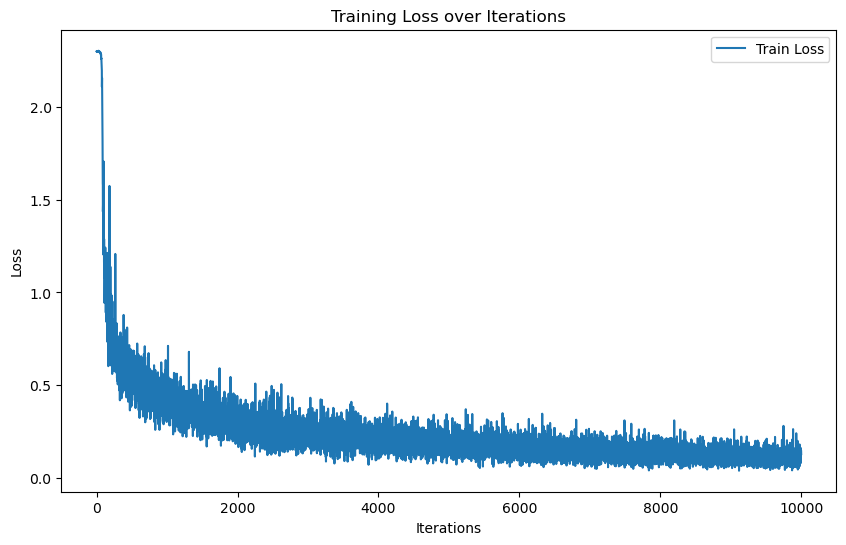

In [20]:
# 손실 함수 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(iters_num), train_loss_list, label='Train Loss')
plt.xlabel('Iterations') 
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()

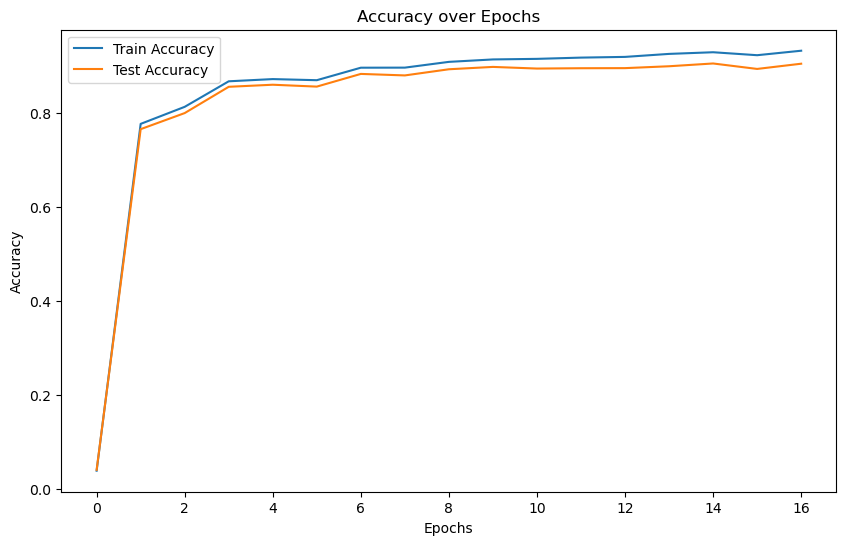

In [21]:

# 정확도 그래프
epochs = range(len(train_acc_list))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()